<a href="https://colab.research.google.com/github/aandreagraziano/aandreagraziano.github.io/blob/master/CSCG%20for%20counterfactual%20causal%20reasoning%20though%20episodic%20memories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCG for episodic memories and counterfactual causal reasoning
Based on https://www.nature.com/articles/s41467-021-22559-5

Code at: http://github.com/vicariousinc/naturecomm_cscg



**Clone the repo from github, Install the necessary libraries**

In [1]:
import sys, os
if not os.path.exists('naturecomm_cscg'):
  print("Cloning naturecomm_cscg repo from github.com/vicariousinc")
  os.system("git clone http://github.com/vicariousinc/naturecomm_cscg")

!pip install cairocffi
!pip install python-igraph==0.9.8

Cloning naturecomm_cscg repo from github.com/vicariousinc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 8.1 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.9.8-py3-none-any.whl size=9063 sha256=567f2a9456ebf9683834d8bf23e694e49d13eddf1b549f7ac6216d5610a2ee80
  Stored in directory: /root/.cache/pip/wheels/90/a0/98/80ea8eb9e079b4723cdb5a7c86e94506e54d1823fde8ffb775
Successfully built python-igraph


***Import the needed python modules***

In [2]:
sys.path.append('naturecomm_cscg')
import numpy as np
from chmm_actions import CHMM, forwardE, datagen_structured_obs_room, forwardE_mp, backtraceE, backtrace, forward_mp, rargmax, forwardE, backtraceE
import matplotlib.pyplot as plt
import igraph
from matplotlib import cm, colors
import os
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
        ]
    )
    / 256
)
if not os.path.exists("figures"):
    os.makedirs("figures")

In [3]:
## A Few utility functions

def plot_graph(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True) ##normalized state transition probabilities

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out, states


def get_mess_fwd(chmm, x, pseudocount=0.0, pseudocount_E=0.0):
    n_clones = chmm.n_clones
    E = np.zeros((n_clones.sum(), len(n_clones)))
    last = 0
    for c in range(len(n_clones)):
        E[last : last + n_clones[c], c] = 1
        last += n_clones[c]
    E += pseudocount_E
    norm = E.sum(1, keepdims=True)
    norm[norm == 0] = 1
    E /= norm
    T = chmm.C + pseudocount
    norm = T.sum(2, keepdims=True)
    norm[norm == 0] = 1
    T /= norm
    T = T.mean(0, keepdims=True)
    log2_lik, mess_fwd = forwardE(
        T.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, x*0 , store_messages=True
    )
    return mess_fwd, E, T


def place_field(mess_fwd, rc, clone):
    assert mess_fwd.shape[0] == rc.shape[0] and clone < mess_fwd.shape[1]
    field = np.zeros(rc.max(0) + 1)
    count = np.zeros(rc.max(0) + 1, int)
    for t in range(mess_fwd.shape[0]):
        r, c = rc[t]
        field[r, c] += mess_fwd[t, clone]
        count[r, c] += 1
    count[count == 0] = 1
    return field / count


# Quickly train a CSCG on a rectangular aliased room that has only 4 unique observations

In [4]:
def generate_sequence(sequence_length):

    transition_matrix = np.array([
        [0.0, 0.7, 0.3, 0.0],   # Transition probabilities from S
        [0.0, 0.0, 0.3, 0.7],   # Transition probabilities from T
        [0.7, 0.0, 0.0, 0.3],   # Transition probabilities from C when arriving from T
        [1.0, 0.0, 0.0, 0.0]    # Transition probabilities from A
    ])

    observations = ['S', 'T', 'C', 'A']
    sequence = np.empty(sequence_length, dtype=int)

    current_state_index = 0
    for i in range(sequence_length):
        sequence[i] = current_state_index
        if (current_state_index==2 and sequence[i-1]==0):
          next_state_probs = [0.0, 0.0, 0.0, 1.0]
        else:
          next_state_probs = transition_matrix[current_state_index]
        #print('current state:', observations[current_state_index])
        #print('probs:', next_state_probs)
        next_state_index = np.random.choice(len(next_state_probs), p=next_state_probs)

        current_state_index = next_state_index

    return sequence

In [5]:
# Generate data and train a CSCG.

n_emissions = 4
length = 1000
#sequence, actions = generate_sequence_w_actions(300)
sequence = generate_sequence(length)
actions = np.full(length, 0)
x, a = sequence, actions

n_clones = np.ones(n_emissions, dtype=np.int64) * 80
chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=42)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=100)  # Training   use n_iter=1000 for better training


Average number of clones: 80.0


100%|██████████| 100/100 [00:22<00:00,  4.45it/s, train_bps=0.592]


In [ ]:
sequence[:20]

array([0, 1, 3, 0, 1, 2, 0, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2, 0, 1])

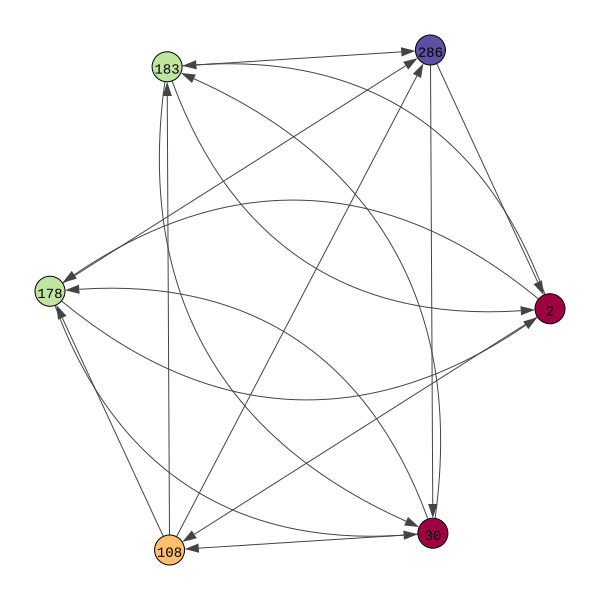

In [6]:
# Plot graph without viterbi
graph, states = plot_graph(
    chmm, x, a, output_file="figures/rectangular_room_graph.pdf"
)
graph

(array([1070.,   51.,   44.,   14.,   17.,    7.,    6.,    2.,    3.,
           2.]),
 array([ 0.        ,  1.85238993,  3.70477986,  5.55716991,  7.40955973,
         9.26194954, 11.11433983, 12.96672916, 14.81911945, 16.67150879,
        18.52389908]),
 <BarContainer object of 10 artists>)

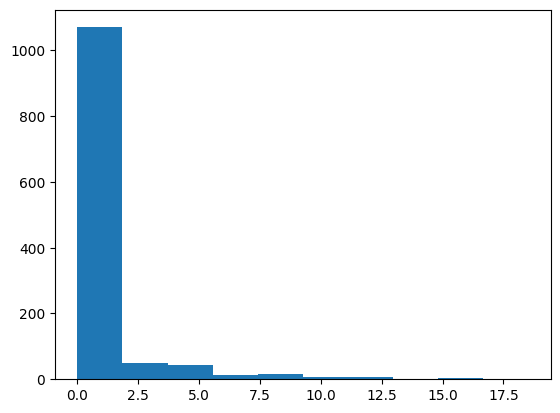

In [ ]:
plt.hist(np.unique(chmm.C))

In [7]:
# Consolidate learning. Takes a few seconds
#chmm.pseudocount = .5
chmm.learn_viterbi_T(x, a, n_iter=100)

  3%|▎         | 3/100 [00:00<00:03, 27.75it/s, train_bps=0.569]


[2.3458965, 0.56917274, 0.5691689, 0.5691689]

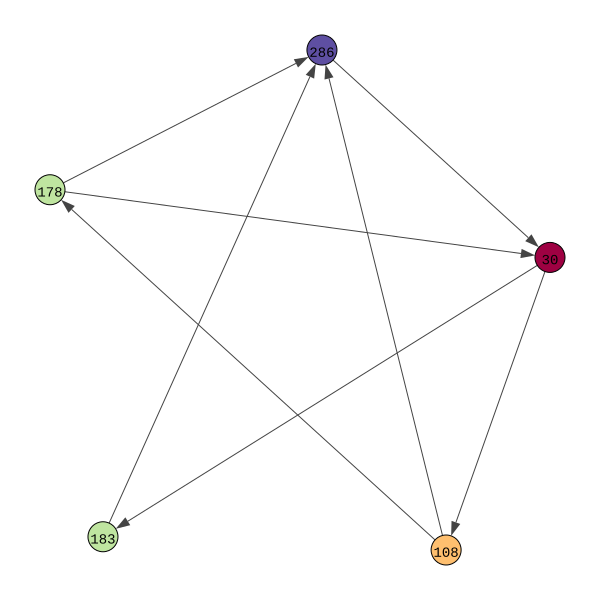

In [8]:
# Visualize the learned, consolidated CSCG.

graph, states = plot_graph(
    chmm, x, a, output_file="figures/rectangular_room_graph.pdf"
)

graph
# Look for the correspondence between the graph and the original layout of the rooom in Figure 1
# Node colors correspond to the observations from the room. Node numbers are the clone numbers.

In [9]:
states = chmm.decode(x, a)[1]
v = np.unique(states)
active_clones = v
T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
A = T.sum(0)
A /= A.sum(1, keepdims=True)
mess_fwd, E, T = get_mess_fwd(chmm, x, pseudocount_E=0.0001)

A, states.shape, active_clones

<ipython-input-9-6b8705582a3f>:6: RuntimeWarning: invalid value encountered in divide
  A /= A.sum(1, keepdims=True)


(array([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], dtype=float32),
 (1000,),
 array([ 30, 108, 178, 183, 286]))

In [ ]:
x[:20], states[:20]

(array([0, 2, 3, 0, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 3, 0, 1, 3, 0, 1]),
 array([ 30, 183, 286,  30, 183, 286,  30, 183, 286,   2, 108, 286,   2,
        108, 286,   2, 108, 286,   2, 108]))

In [10]:
#Restrict Pi, T, and E matrices to active clones only.

num_active_clones = len(active_clones)

Pi_x_restricted = chmm.Pi_x[:num_active_clones]

T=chmm.T.copy()
T_restricted = np.zeros((T.shape[0], num_active_clones, num_active_clones))

for i in range(num_active_clones):
    for j in range(num_active_clones):
        original_i = active_clones[i]
        original_j = active_clones[j]
        T_restricted[:, i, j] = T[:, original_i, original_j]

clone_correspondence = {}
for i in range(num_active_clones):
    original_i = active_clones[i]
    clone_correspondence[i] = original_i


num_active_clones = len(active_clones)
E_restricted = np.zeros((num_active_clones, E.shape[1]))

for i in range(num_active_clones):
    original_i = clone_correspondence[i]
    E_restricted[i, :] = E[original_i, :]

In [58]:
#Block transition from to a specific node on the restricted T matrix.

T_restricted_blocked = T_restricted.copy()
clones_blocked_in_original = [108] #Starting node
clones_blocked_out_original = [286] #Ending node
idxs_blocked_in = []
idxs_blocked_out = []

for clone in clones_blocked_in_original:
  blocked_obs = clone//n_clones[0]
  for index, node in clone_correspondence.items():
    if node == clone:
      idxs_blocked_in.append(index)
      break

for clone in clones_blocked_out_original:
  blocked_obs = clone//n_clones[0]
  for index, node in clone_correspondence.items():
    if node == clone:
      idxs_blocked_out.append(index)
      break

for idx_blocked_in in idxs_blocked_in:
  for idx_blocked_out in idxs_blocked_out:
    T_restricted_blocked[:, idx_blocked_in, idx_blocked_out] = chmm.pseudocount
    T_restricted_blocked[:, idx_blocked_out, idx_blocked_in] = chmm.pseudocount

#T_restricted_blocked[T_restricted_blocked < 0.02] = 0

# Normalize to adjust probabilities
norm = T_restricted_blocked.sum(2, keepdims=True)
norm[norm == 0] = 1
T_restricted_blocked /= norm

norm = E.sum(1, keepdims=True)
norm[norm == 0] = 1
E /= norm

In [59]:
#Plot the updated graph, with the adjusted probabilities and blocked transitions.

def plot_graph_blocked(
    chmm, x, a, output_file, T_restricted_blocked, cmap=plt.cm.Spectral, multiple_episodes=False, vertex_size=30, edge_color='black', marked_transition=None
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(chmm.n_clones)[v]
    max_label = node_labels.max()
    colors = [cmap(nl / max_label)[:3] for nl in node_labels]

    edge_colors = ['black'] * len(g.es)

    if marked_transition is not None:
        source, target = marked_transition
        edge_idx = g.get_eid(source, target, directed=True, error=False)
        if edge_idx != -1:
            edge_colors[edge_idx] = 'red'


    # Define legend and layout (x, y spacing)
    category_ranges = np.linspace(0, max_label, 4)
    category_labels = ['Station', 'Train', 'Cab', 'Airport']
    legend_labels = []
    y_positions = {}
    base_y_coord = 0
    category_x_coords = {}
    x_spacing = 1000
    train_y_offset = -1
    cab_y_offset = -1
    for i, label in enumerate(category_labels):
        color = cmap(category_ranges[i] / max_label)[:3]
        legend_labels.append((label, color))
        category_x_coords[label] = i * x_spacing

    category_counts = {label: 0 for label in category_labels}
    node_categories = np.digitize(node_labels, category_ranges) - 1

    layout = []
    for idx, nl in enumerate(node_labels):
        category = category_labels[node_categories[idx]]
        x_coord = category_x_coords[category]
        # Adjust y-coordinates
        if category == "Train":
            y_coord = train_y_offset + (category_counts[category] * -1)
        elif category == "Cab":
            y_coord = cab_y_offset + (category_counts[category] * -1)
        else:
            y_coord = category_counts[category] *-1
        category_counts[category] -= 2
        layout.append((x_coord, y_coord))


    # Set edge labels based on transition probabilities
    for e in g.es:
        source = e.source
        target = e.target
        e['label'] = f"p={T_restricted_blocked[0, source, target]:.2f}"

    out = igraph.plot(
        g,
        None,
        layout=layout,
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
        edge_color=edge_colors,
        legend=legend_labels,
        legend_box=(1, 0)
    )

    legend_fig, legend_ax = plt.subplots(figsize=(2, 2))
    legend_ax.axis('off')
    legend_ax.legend(handles=[Line2D([0], [0], marker='o', color='w', label=label,
                                      markerfacecolor=color, markersize=10)
                              for label, color in legend_labels],
                     loc='center')
    plt.show()
    legend_fig.show()

    return out, states

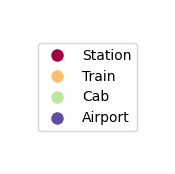

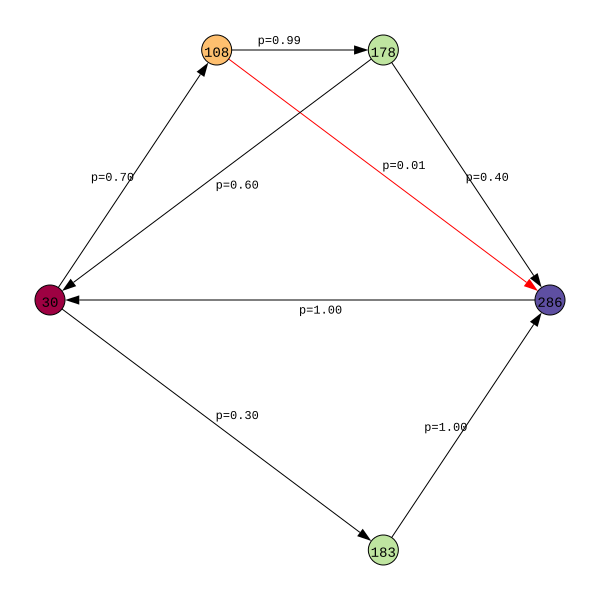

In [60]:
output_file = "figures/rectangular_room_graph.pdf"
plot_result, states = plot_graph_blocked(chmm, x, a, output_file, T_restricted_blocked, marked_transition=(1, 4))
plot_result
